In [1]:
!pip install keras==2.4.3

  Attempting uninstall: keras
    Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
from sklearn.utils import shuffle
from getpass import getpass
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import imageio
from skimage import img_as_float
from scipy.fftpack import fft2, ifft2, fftshift
from collections import OrderedDict, defaultdict
from scipy.ndimage.filters import gaussian_filter, median_filter, maximum_filter, minimum_filter
import random
import os


from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from glob import glob
from tqdm import tqdm
from PIL import Image




path = '/kaggle/input/data/'
bbox_csv = 'BBox_List_2017.csv'
data_csv = 'Data_Entry_2017.csv'
imgs_folders = ['images_001', 'images_002', 'images_003',
       'images_004', 'images_005', 'images_006', 'images_007',
       'images_008', 'images_009', 'images_010', 'images_011',
       'images_012']
Categories = ['No Finding','Atelectasis', 'Cardiomegaly', 'Consolidation',
        'Edema', 'Effusion', 'Fibrosis', 'Infiltration', 'Mass',
        'Pneumothorax', 'Emphysema', 'Pneumonia', 'Pleural_Thickening',
        'Nodule', 'Hernia']


def Add_path(df, path = '/kaggle/input/data/images*/images/*.png'):
    my_glob = glob(path)
    full_img_paths = {os.path.basename(x): x for x in my_glob}
    dataset_path = df['Image Index'].map(full_img_paths.get)
    df['full_path'] = dataset_path
    return df


def Adjust_data(data):
    data = data[['Image Index', 'Finding Labels']]
    #data = data[data['Finding Labels'] != 'No Finding']
    new_data = data.rename(columns={'Finding Labels': 'All Labels'})
    return new_data


def dfcat2dfid(df, Categories): # change dataframe of category names into category numbers
    cat2id = {i:j for j,i in enumerate(Categories)}
    id2cat = {i:j for i,j in enumerate(Categories)}

    All_Cat = df['All Labels'].values.astype(str)
    All_cat_list = [i.split('|') for i in All_Cat]

    mcs_All_Labels = np.array([np.array([cat2id[p] for p in o]) for o in All_cat_list])

    df['Class_All'] = mcs_All_Labels
    
    return df


In [3]:
df = pd.read_csv(path + data_csv)

df = Adjust_data(df)
df = dfcat2dfid(df, Categories)
df = Add_path(df)

df.head()

,Image Index,All Labels,Class_All,full_path
0,00000001_000.png,Cardiomegaly,[2],/kaggle/input/data/images_001/images/00000001_...
1,00000001_001.png,Cardiomegaly|Emphysema,"[2, 10]",/kaggle/input/data/images_001/images/00000001_...
2,00000001_002.png,Cardiomegaly|Effusion,"[2, 5]",/kaggle/input/data/images_001/images/00000001_...
3,00000002_000.png,No Finding,[0],/kaggle/input/data/images_001/images/00000002_...
4,00000003_000.png,Hernia,[14],/kaggle/input/data/images_001/images/00000003_...


In [4]:
Negative = df[df['All Labels'] == 'No Finding'][:1000]
Cardiomegaly = df[df['All Labels']=='Cardiomegaly'][:1000]
Emphysema = df[df['All Labels']=='Emphysema']
Hernia = df[df['All Labels']=='Hernia']
Effusion = df[df['All Labels']=='Effusion'][:1000]
Atelectasis = df[df['All Labels']=='Atelectasis'][:1000]
Consolidation = df[df['All Labels']=='Consolidation'][:1000]
Pleural_Thickening = df[df['All Labels']=='Pleural_Thickening'][:1000]
Nodule = df[df['All Labels']=='Nodule'][:1000]
Fibrosis = df[df['All Labels']=='Fibrosis']
Infiltration = df[df['All Labels']=='Infiltration'][:1000]
Mass = df[df['All Labels']=='Mass'][:1000]
Pneumothorax = df[df['All Labels']=='Pneumothorax'][:1000]
Pneumonia = df[df['All Labels']=='Pneumonia']
Edema = df[df['All Labels']=='Edema']

In [5]:
print('length of No Finding = {}\n'.format(len(Negative)))
print('length of Cardiomegaly = {}\n'.format(len(Cardiomegaly)))
print('length of Emphysema = {}\n'.format(len(Emphysema)))
print('length of Hernia = {}\n'.format(len(Hernia)))
print('length of Effusion = {}\n'.format(len(Effusion)))
print('length of Atelectasis = {}\n'.format(len(Atelectasis)))
print('length of Consolidation = {}\n'.format(len(Consolidation)))
print('length of Pleural_Thickening = {}\n'.format(len(Pleural_Thickening)))
print('length of Mass = {}\n'.format(len(Mass)))
print('length of Infiltration = {}\n'.format(len(Infiltration)))
print('length of Pneumonia = {}\n'.format(len(Pneumonia)))
print('length of Pneumothorax = {}\n'.format(len(Pneumothorax)))
print('length of Nodule = {}\n'.format(len(Nodule)))
print('length of Fibrosis = {}\n'.format(len(Fibrosis)))
print('length of Edema = {}\n'.format(len(Edema)))


length of No Finding = 1000

length of Cardiomegaly = 1000

length of Emphysema = 892

length of Hernia = 110

length of Effusion = 1000

length of Atelectasis = 1000

length of Consolidation = 1000

length of Pleural_Thickening = 1000

length of Mass = 1000

length of Infiltration = 1000

length of Pneumonia = 322

length of Pneumothorax = 1000

length of Nodule = 1000

length of Fibrosis = 727

length of Edema = 628



In [6]:
mixed = df[df['Class_All'].map(len) > 1]

In [7]:
New_df = pd.concat([Negative, Atelectasis, Cardiomegaly, Consolidation, Edema, Effusion,
                    Fibrosis, Infiltration, Mass, Pneumothorax, Emphysema,
                    Pneumonia, Pleural_Thickening, Nodule, Hernia], ignore_index = True )
print(len(New_df))
New_df.head()

12679


,Image Index,All Labels,Class_All,full_path
0,00000002_000.png,No Finding,[0],/kaggle/input/data/images_001/images/00000002_...
1,00000005_000.png,No Finding,[0],/kaggle/input/data/images_001/images/00000005_...
2,00000005_001.png,No Finding,[0],/kaggle/input/data/images_001/images/00000005_...
3,00000005_002.png,No Finding,[0],/kaggle/input/data/images_001/images/00000005_...
4,00000005_003.png,No Finding,[0],/kaggle/input/data/images_001/images/00000005_...


In [8]:
total_df = pd.concat([New_df, mixed], ignore_index = True)

print(len(total_df))
total_df.head()

33475


,Image Index,All Labels,Class_All,full_path
0,00000002_000.png,No Finding,[0],/kaggle/input/data/images_001/images/00000002_...
1,00000005_000.png,No Finding,[0],/kaggle/input/data/images_001/images/00000005_...
2,00000005_001.png,No Finding,[0],/kaggle/input/data/images_001/images/00000005_...
3,00000005_002.png,No Finding,[0],/kaggle/input/data/images_001/images/00000005_...
4,00000005_003.png,No Finding,[0],/kaggle/input/data/images_001/images/00000005_...


In [9]:
mc = []
for i in New_df['Class_All'].values:
    c = np.zeros(len(Categories) ,dtype=int)
    c[i] = 1 
    mc.append(c)

In [10]:
for i in mixed['Class_All'].values:
    c = np.zeros(len(Categories) ,dtype=int)
    for p in i:
        c[p]=1
    mc.append(c)

In [11]:
mc = np.asarray(mc)

In [12]:
mc_df =pd.DataFrame(mc,columns=Categories)

print(len(mc_df))
mc_df.tail()

33475


,No Finding,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Fibrosis,Infiltration,Mass,Pneumothorax,Emphysema,Pneumonia,Pleural_Thickening,Nodule,Hernia
33470,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0
33471,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0
33472,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
33473,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
33474,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0


In [13]:
data_df = shuffle(pd.concat([total_df, mc_df], axis=1).drop(columns = ['All Labels', 'Class_All'])).reset_index(drop=True)
print(len(data_df))
data_df.head()

33475


,Image Index,full_path,No Finding,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Fibrosis,Infiltration,Mass,Pneumothorax,Emphysema,Pneumonia,Pleural_Thickening,Nodule,Hernia
0,00015044_005.png,/kaggle/input/data/images_007/images/00015044_...,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
1,00014332_008.png,/kaggle/input/data/images_007/images/00014332_...,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,00021976_008.png,/kaggle/input/data/images_010/images/00021976_...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
3,00001561_003.png,/kaggle/input/data/images_002/images/00001561_...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,00017981_032.png,/kaggle/input/data/images_008/images/00017981_...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [14]:
data_df['disease_vec'] = data_df.apply(lambda x: [x[Categories].values.astype('uint8')], 1).map(lambda x: x[0])

In [15]:
from sklearn.model_selection import train_test_split

train_and_valid_df, test_df = train_test_split(data_df,
                                               test_size = 0.30,
                                               random_state = 2018,
                                              )

train_df, valid_df = train_test_split(train_and_valid_df,
                                      test_size=0.30,
                                      random_state=2018,
                                     )

print(f'Train {train_df.shape[0]} Valid {valid_df.shape[0]} Test: {test_df.shape[0]}')

Train 16402 Valid 7030 Test: 10043


In [16]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (256, 256)
core_idg = ImageDataGenerator(rescale=1./255,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              zoom_range=0.15)

In [17]:
def flow_from_dataframe(image_generator, dataframe, batch_size):

    df_gen = image_generator.flow_from_dataframe(dataframe,
                                                 x_col='full_path',
                                                 y_col=Categories,
                                                 target_size=IMG_SIZE,
                                                 classes=Categories,
                                                 color_mode='rgb',
                                                 class_mode='raw',
                                                 shuffle=False,
                                                 batch_size=batch_size)
    
    return df_gen

In [18]:
train_gen = flow_from_dataframe(image_generator=core_idg, 
                                dataframe= train_df,
                                batch_size = 32)

valid_gen = flow_from_dataframe(image_generator=core_idg, 
                                dataframe=valid_df,
                                batch_size = 32)

test_gen = flow_from_dataframe(image_generator=core_idg, 
                               dataframe=test_df,
                               batch_size = 32)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:220: UserWarning: `classes` will be ignored given the class_mode="raw"
  .format(self.class_mode))


Found 16402 validated image filenames.
Found 7030 validated image filenames.
Found 10043 validated image filenames.


In [19]:
a,b = next(iter(train_gen))

In [20]:
a.shape

(32, 256, 256, 3)

In [21]:
b.shape

(32, 15)

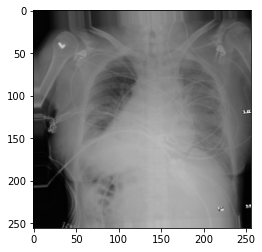

In [22]:
plt.imshow(a[3])

In [23]:
b[3]

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [24]:
import keras.backend as kb
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
import shutil
import warnings
import json

class MultipleClassAUROC(Callback):
    """
    Monitor mean AUROC and update model
    """
    def __init__(self, generator, class_names, weights_path, stats=None):
        super(Callback, self).__init__()
        self.generator = generator
        self.class_names = class_names
        self.weights_path = weights_path
        self.best_weights_path = os.path.join(
            os.path.split(weights_path)[0],
            f"best_{os.path.split(weights_path)[1]}",
        )
        self.best_auroc_log_path = os.path.join(
            os.path.split(weights_path)[0],
            "best_auroc.log",
        )
        self.stats_output_path = os.path.join(
            os.path.split(weights_path)[0],
            ".training_stats.json"
        )
        # for resuming previous training
        if stats:
            self.stats = stats
        else:
            self.stats = {"best_mean_auroc": 0}

        # aurocs log
        self.aurocs = {}
        for c in self.class_names:
            self.aurocs[c] = []

    def on_epoch_end(self, epoch, logs={}):
        """
        Calculate the average of the ROC Curves and save the best group of weights according to this metric
        """
        print("\n*********************************")
        self.stats["lr"] = float(kb.eval(self.model.optimizer.lr))
        print(f"Learning Rate actual: {self.stats['lr']}")

        """
        y_hat shape: (#ex, len(labels))
        y: [(#ex, 1), (#ex, 1) ... (#ex, 1)]
        """
        y_hat = self.model.predict_generator(self.generator,steps=self.generator.n/self.generator.batch_size)
        y = self.generator.labels

        print(f"*** epoch#{epoch + 1} Curvas ROC Training Phase ***")
        current_auroc = []
        for i in range(len(self.class_names)):
            try:
                score = roc_auc_score(y[:, i], y_hat[:, i])
            except ValueError:
                score = 0
            self.aurocs[self.class_names[i]].append(score)
            current_auroc.append(score)
            print(f"{i+1}. {self.class_names[i]}: {score}")
        print("*********************************")

        mean_auroc = np.mean(current_auroc)
        print(f"Average ROC Curves: {mean_auroc}")
        if mean_auroc > self.stats["best_mean_auroc"]:
            print(f"Update of the result of the ROC Curves of: {self.stats['best_mean_auroc']} a {mean_auroc}")

            # 1. copy best model
            shutil.copy(self.weights_path, self.best_weights_path)

            # 2. update log file
            print(f"Log file update: {self.best_auroc_log_path}")
            with open(self.best_auroc_log_path, "a") as f:
                f.write(f"(epoch#{epoch + 1}) auroc: {mean_auroc}, lr: {self.stats['lr']}\n")

            # 3. write stats output, this is used for resuming the training
            with open(self.stats_output_path, 'w') as f:
                json.dump(self.stats, f)

            print(f"Weight group update: {self.weights_path} -> {self.best_weights_path}")
            self.stats["best_mean_auroc"] = mean_auroc
            print("*********************************")
        return

In [25]:
import keras.backend as K
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import GlobalAveragePooling2D
from keras.layers import ZeroPadding2D
from keras.layers import Dense
from keras.models import Model
from keras.engine import get_source_inputs

import keras
from distutils.version import StrictVersion

#if StrictVersion(keras.__version__) < StrictVersion('2.2.0'):
 #   from keras.applications.imagenet_utils import _obtain_input_shape
#else:
 #   from keras_applications.imagenet_utils import _obtain_input_shape

def build_resnet(
     repetitions=(2, 2, 2, 2),
     include_top=True,
     input_tensor=None,
     input_shape=None,
     classes=1000,
     block_type='usual'):

    # Determine proper input shape
    input_shape = (1024, 1024, 3)
    img_input = Input(shape=input_shape)

    # get parameters for model layers
    no_scale_bn_params = get_bn_params(scale=False)
    bn_params = get_bn_params()
    conv_params = get_conv_params()
    init_filters = 64

    if block_type == 'basic':
        conv_block = basic_conv_block
        identity_block = basic_identity_block
    else:
        conv_block = usual_conv_block
        identity_block = usual_identity_block
    
    # resnet bottom
    x = BatchNormalization(name='bn_data', **no_scale_bn_params)(img_input)
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(init_filters, (7, 7), strides=(2, 2), name='conv0', **conv_params)(x)
    x = BatchNormalization(name='bn0', **bn_params)(x)
    x = Activation('relu', name='relu0')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x)
    
    # resnet body
    for stage, rep in enumerate(repetitions):
        for block in range(rep):
            
            filters = init_filters * (2**stage)
            
            # first block of first stage without strides because we have maxpooling before
            if block == 0 and stage == 0:
                x = conv_block(filters, stage, block, strides=(1, 1))(x)
                
            elif block == 0:
                x = conv_block(filters, stage, block, strides=(2, 2))(x)
                
            else:
                x = identity_block(filters, stage, block)(x)
                
    x = BatchNormalization(name='bn1', **bn_params)(x)
    x = Activation('relu', name='relu1')(x)

    # resnet top
    if include_top:
        x = GlobalAveragePooling2D(name='pool1')(x)
        x = Dense(classes, name='fc1')(x)
        x = Activation('softmax', name='softmax')(x)

    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
        
    # Create model.
    model = Model(img_input, x)

    return model


weights_collection = [
    {
        'dataset': 'imagenet',
        'classes': 1000,
        'include_top': False,
        'url': 'https://github.com/qubvel/classification_models/releases/download/0.0.1/resnet34_imagenet_1000_no_top.h5',
        'name': 'resnet34_imagenet_1000_no_top.h5',
        'md5': '8caaa0ad39d927cb8ba5385bf945d582',
    },
]

def get_conv_params(**params):
    default_conv_params = {
        'kernel_initializer': 'glorot_uniform',
        'use_bias': False,
        'padding': 'valid',
    }
    default_conv_params.update(params)
    return default_conv_params

def get_bn_params(**params):
    default_bn_params = {
        'axis': 3,
        'momentum': 0.99,
        'epsilon': 2e-5,
        'center': True,
        'scale': True,
    }
    default_bn_params.update(params)
    return default_bn_params

def handle_block_names(stage, block):
    name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
    conv_name = name_base + 'conv'
    bn_name = name_base + 'bn'
    relu_name = name_base + 'relu'
    sc_name = name_base + 'sc'
    return conv_name, bn_name, relu_name, sc_name


def basic_identity_block(filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        x = Add()([x, input_tensor])
        return x

    return layer


def basic_conv_block(filters, stage, block, strides=(2, 2)):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        shortcut = Conv2D(filters, (1, 1), name=sc_name, strides=strides, **conv_params)(shortcut)
        x = Add()([x, shortcut])
        return x

    return layer


def usual_conv_block(filters, stage, block, strides=(2, 2)):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = Conv2D(filters, (1, 1), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '2', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Conv2D(filters*4, (1, 1), name=conv_name + '3', **conv_params)(x)

        shortcut = Conv2D(filters*4, (1, 1), name=sc_name, strides=strides, **conv_params)(shortcut)
        x = Add()([x, shortcut])
        return x

    return layer


def usual_identity_block(filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        x = Conv2D(filters, (1, 1), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Conv2D(filters*4, (1, 1), name=conv_name + '3', **conv_params)(x)

        x = Add()([x, input_tensor])
        return x

    return layer

from keras.utils import get_file


def find_weights(weights_collection, model_name, dataset, include_top):
    w = list(filter(lambda x: x['dataset'] == dataset, weights_collection))
    w = list(filter(lambda x: x['include_top'] == include_top, w))
    return w


def load_model_weights(weights_collection, model, dataset, classes, name,  include_top):
    weights = find_weights(weights_collection, name, dataset, include_top)

    if weights:
        weights = weights[0]

        if include_top and weights['classes'] != classes:
            raise ValueError('If using `weights` and `include_top`'
                             ' as true, `classes` should be {}'.format(weights['classes']))

        weights_path = get_file(weights['name'],
                                weights['url'],
                                cache_subdir='models',
                                md5_hash=weights['md5'])

        model.load_weights(weights_path)

    else:
        raise ValueError('There is no weights for such configuration: ' +
                         'model = {}, dataset = {}, '.format(model.name, dataset) +
                         'classes = {}, include_top = {}.'.format(classes, include_top))

def ResNet34(input_shape, input_tensor=None, weights=None, classes=1000, include_top=True):
    model = build_resnet(input_tensor=input_tensor,
                         input_shape=input_shape,
                         repetitions=(3, 4, 6, 3),
                         classes=classes,
                         include_top=include_top,
                         block_type='basic')
    
    name=model.name

    if weights:
        load_model_weights(weights_collection, model, weights, classes, name, include_top)
    return model

In [26]:
from keras.models import Model
import keras.backend as K
from keras import Sequential


backbone = ResNet34(input_shape=(256,256,3), weights='imagenet', classes=1000,include_top=False)

x=backbone.output

prob_map = Conv2D(1, (1, 1), activation='sigmoid', name='classifier')(x)

weight_map = prob_map /  K.sum(prob_map, [2,3], keepdims=True)

feature = x * weight_map

features = K.sum(feature, [2,3], keepdims=True)

a= BatchNormalization()(features)

out1 = Dropout(0.2)(a)

out2 = Conv2D(15, (1, 1), activation='relu', name='classifier_2')(out1)

out3 = GlobalAveragePooling2D()(out2)

out = Dense(15, activation='sigmoid')(out3)


Res_model = Model(inputs=backbone.input, outputs=out, name="Resnet34_model")

85524480/85521592 [==============================] - 1s 0us/step


In [27]:
#%% compile and train the VGG16 custom model
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.optimizers import Adam, SGD

epochs = 20
#sgd = SGD(lr=1e-5, decay=1e-6, momentum=0.95, nesterov=True) 
sgd= keras.optimizers.Adam(lr=1e-3)
Res_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy']) 

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5,
                              verbose=1, mode='max', min_lr=0.00001)

output_weights_name='weights.h5'
checkpoint = ModelCheckpoint(
             output_weights_name,
             save_weights_only=True,
             save_best_only=True,
             verbose=1,
            )

training_stats = {}
auroc = MultipleClassAUROC(
    generator=valid_gen,
    class_names=Categories,
    weights_path=output_weights_name,
    stats=training_stats
)

callbacks_list = [checkpoint, reduce_lr, auroc]




In [28]:
history = Res_model.fit_generator(
    generator=train_gen,
    steps_per_epoch=train_gen.n/train_gen.batch_size,
    epochs=10,
    validation_data=valid_gen,
    validation_steps=valid_gen.n/valid_gen.batch_size,
    callbacks=callbacks_list,
    shuffle=False
)

Epoch 1/10
513/512 [==============================] - ETA: 0s - loss: 0.4230 - accuracy: 0.0885
Epoch 00001: val_loss improved from inf to 0.36822, saving model to weights.h5

*********************************
Learning Rate actual: 0.0010000000474974513
*** epoch#1 Curvas ROC Training Phase ***
1. No Finding: 0.4480539408142354
2. Atelectasis: 0.5119312353490809
3. Cardiomegaly: 0.517587199295688
4. Consolidation: 0.5451466904535497
5. Edema: 0.6405395953051993
6. Effusion: 0.5179234932498353
7. Fibrosis: 0.4056290854669799
8. Infiltration: 0.5055227588759507
9. Mass: 0.4863037306587019
10. Pneumothorax: 0.41872526238173524
11. Emphysema: 0.46359663093415004
12. Pneumonia: 0.5518366929294996
13. Pleural_Thickening: 0.4607391968469938
14. Nodule: 0.4799548900316425
15. Hernia: 0.4304269462266023
*********************************
Average ROC Curves: 0.49226115658798963
Update of the result of the ROC Curves of: 0 a 0.49226115658798963
Log file update: best_auroc.log
Weight group update: 

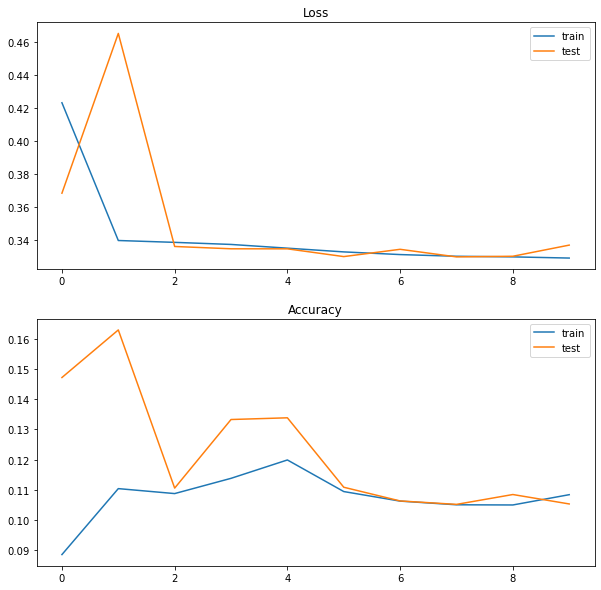

In [29]:
# plot loss during training
plt.figure(figsize= (10,10))
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()

plt.show()


In [30]:
pred_y = Res_model.predict_generator(test_gen, steps=test_gen.n/test_gen.batch_size, verbose = True)

314/313 [==============================] - 382s 1s/step


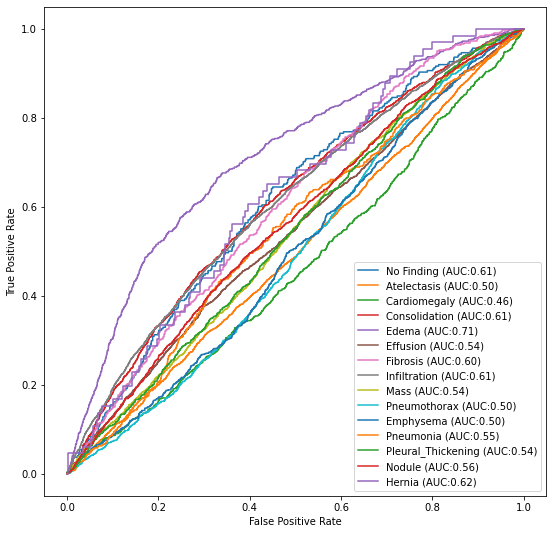

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
test_gen.reset()
test_x, test_y = next(test_gen)
# Space
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(Categories):
    #Points to graph
    fpr, tpr, thresholds = roc_curve(test_gen.labels[:,idx].astype(int), pred_y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    
#convention
c_ax.legend()

#Labels
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

# Save as a png
fig.savefig('barely_trained_net.png')

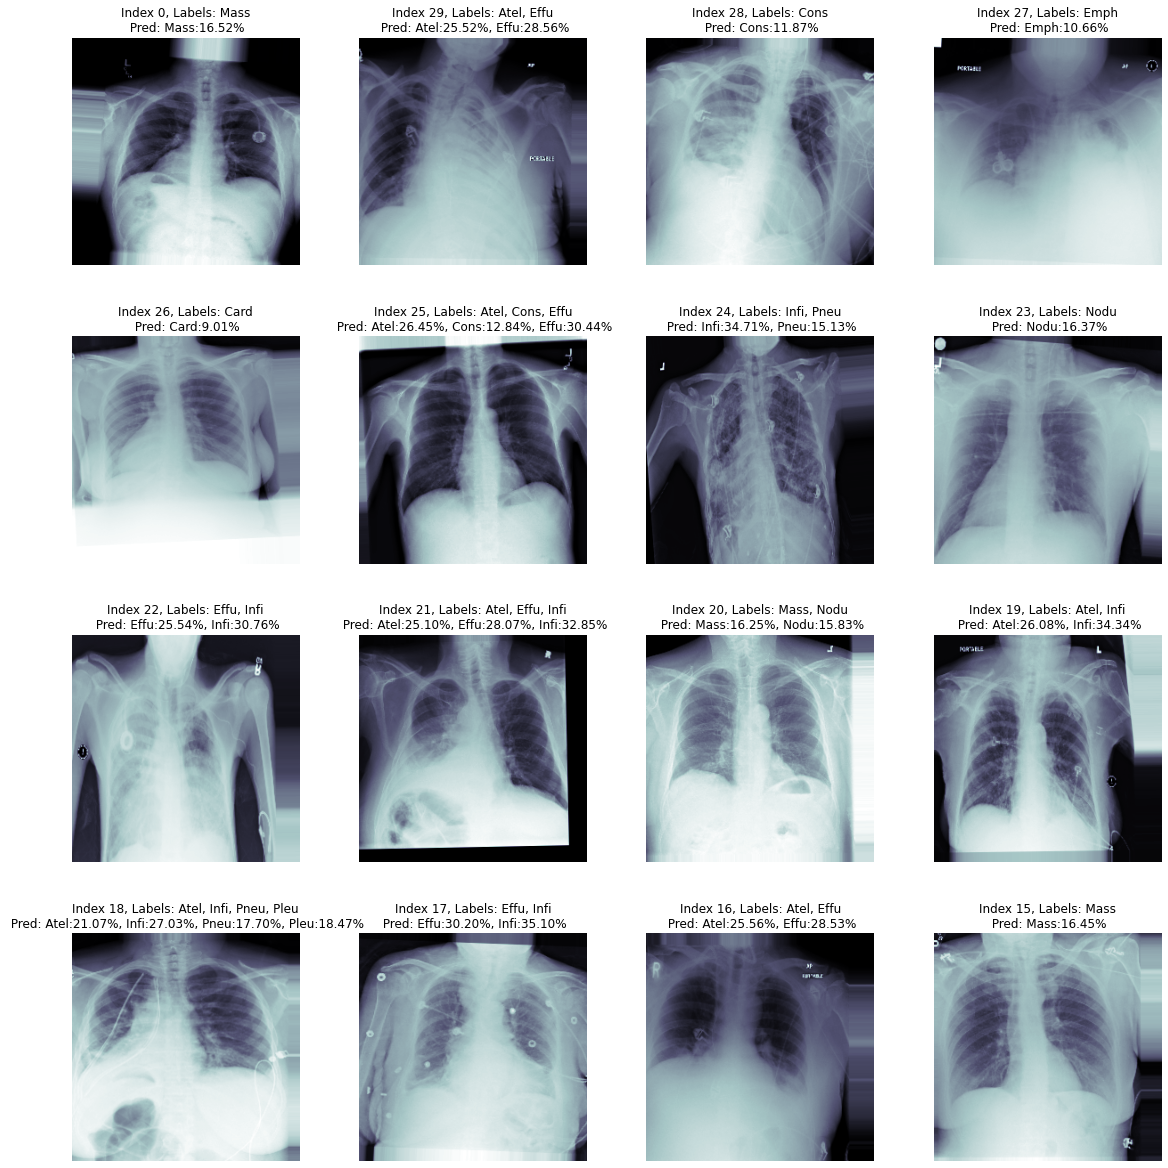

In [32]:
sickest_idx = np.argsort(np.sum(test_y, 1)<1)

#Space of images
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))

# Padding
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
counter = 0

for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    
    # Image show
    c_ax.imshow(test_x[idx, :,:,0], cmap = 'bone')
    
    stat_str = [n_class[:4] for n_class, n_score in zip(Categories, test_y[idx]) if n_score>0.5]
        
    # Building the labels
    pred_str = [f'{n_class[:4]}:{p_score*100:.2f}%'
                for n_class, n_score, p_score 
                in zip(Categories,test_y[idx],pred_y[idx]) 
                if (n_score>0.5) or (p_score>0.5)]
    
    c_ax.set_title(f'Index {idx}, Labels: '+', '.join(stat_str)+'\n Pred: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')